In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install ipython-autotime

#%load_ext autotime

In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [3]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [4]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [5]:
tqdm = partial(tqdm, position=0, leave=True)

In [6]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:61]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[60:120]:
  right_files_path.append(folder_path + file)

In [7]:
print(len(files_all))

176


In [8]:
from multiprocessing import Pool

In [9]:
import multiprocessing
print(multiprocessing.cpu_count())


2


In [10]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC )
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.5,fy=0.5, interpolation = cv2.INTER_CUBIC )
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 60/60 [01:00<00:00,  1.02s/it]


In [13]:
Dataset = 'MAP Dataset'

In [12]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 12.09605884552002 [s] ... size 1811.54048 MB


In [14]:
f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 22.958483695983887 [s] ... size 2415.386624 MB


In [15]:
del images_left_bgr,images_right_bgr

In [16]:
from timeit import default_timer as timer

In [17]:
time_all = []

In [18]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []


BRISK

In [ ]:
Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

In [20]:
all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [21]:
all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [22]:
del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [23]:
import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [24]:
import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [25]:
del Fdb, all_feat_brisk_left, all_feat_brisk_right

In [20]:
images_left_bgr=[]
images_right_bgr=[]

MSER + SIFT

In [21]:
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [13:00<00:00, 13.02s/it]


In [22]:
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 20853.35it/s]


In [23]:
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [24]:
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [25]:
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [26]:
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [27]:
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [28]:
del Fdb, all_feat_mser_left, all_feat_mser_right

FAST + SIFT

In [ ]:
'''
start = timer()


fast = cv2.FastFeatureDetector_create(threshold=40)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

In [ ]:
'''
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [ ]:
'''
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [ ]:
'''
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_fast_left, all_feat_fast_right

GFTT + SIFT

In [29]:
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:29<00:00,  2.05it/s]


In [30]:
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 56641.51it/s]


In [31]:
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [32]:
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [33]:
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [34]:
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [35]:
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [36]:
del Fdb, all_feat_gftt_left, all_feat_gftt_right

DAISY+SIFT

In [ ]:
'''
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

In [ ]:
'''
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [ ]:
'''
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [ ]:
'''
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_daisy_left, all_feat_daisy_right

SIFT

In [ ]:
'''
print(len(left_files_path))

In [ ]:
'''
print(len(right_files_path))

In [ ]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [ ]:
# del f

In [ ]:
'''
start = timer()

sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

In [45]:
'''
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [46]:
'''
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [47]:
'''
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_sift_left, all_feat_sift_right

In [ ]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

SURF

In [ ]:
'''
start = timer()

surf  = cv2.xfeatures2d.SURF_create(upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

In [44]:
'''
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [45]:
'''
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [46]:
'''
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surf_left, all_feat_surf_right

Total Matches,Robust Matches and Homography Computation

In [37]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [38]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [39]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [40]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [ ]:
''''
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [ ]:
'''
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [ ]:
'''
H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [ ]:
'''
H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [ ]:
'''
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.7,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.7,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [ ]:
'''
H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [41]:
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [42]:
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [43]:
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

  3%|▎         | 2/61 [00:00<00:08,  7.20it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 216
Number of Robust matches 102



Number of matches 1000
Number of matches After Lowe's Ratio 257
Number of Robust matches 118




  7%|▋         | 4/61 [00:00<00:07,  7.94it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 222
Number of Robust matches 98



Number of matches 1000
Number of matches After Lowe's Ratio 178
Number of Robust matches 83




  8%|▊         | 5/61 [00:00<00:08,  6.41it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 31
Number of Robust matches 5


Number of matches After Lowe's Ratio New 31
Number of Robust matches New 5




 11%|█▏        | 7/61 [00:00<00:07,  7.37it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 385
Number of Robust matches 294



Number of matches 1000
Number of matches After Lowe's Ratio 177
Number of Robust matches 81




 15%|█▍        | 9/61 [00:01<00:06,  8.40it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 238
Number of Robust matches 121



Number of matches 1000
Number of matches After Lowe's Ratio 266
Number of Robust matches 177




 18%|█▊        | 11/61 [00:01<00:05,  8.83it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 250
Number of Robust matches 209



Number of matches 1000
Number of matches After Lowe's Ratio 299
Number of Robust matches 259




 21%|██▏       | 13/61 [00:01<00:05,  9.30it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 311
Number of Robust matches 269



Number of matches 1000
Number of matches After Lowe's Ratio 254
Number of Robust matches 214




 25%|██▍       | 15/61 [00:01<00:04,  9.44it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 250
Number of Robust matches 200



Number of matches 1000
Number of matches After Lowe's Ratio 234
Number of Robust matches 189




 28%|██▊       | 17/61 [00:01<00:04,  9.51it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 245
Number of Robust matches 202



Number of matches 1000
Number of matches After Lowe's Ratio 219
Number of Robust matches 167



Number of matches 1000
Number of matches After Lowe's Ratio 276
Number of Robust matches 242




 33%|███▎      | 20/61 [00:02<00:04,  9.59it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 323
Number of Robust matches 268



Number of matches 1000
Number of matches After Lowe's Ratio 331
Number of Robust matches 311




 36%|███▌      | 22/61 [00:02<00:04,  9.27it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 315
Number of Robust matches 247



Number of matches 1000
Number of matches After Lowe's Ratio 289
Number of Robust matches 189




 38%|███▊      | 23/61 [00:02<00:04,  9.24it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 283
Number of Robust matches 161



Number of matches 1000
Number of matches After Lowe's Ratio 174
Number of Robust matches 100




 41%|████      | 25/61 [00:02<00:04,  7.85it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 36
Number of Robust matches 6


Number of matches After Lowe's Ratio New 36
Number of Robust matches New 6




 44%|████▍     | 27/61 [00:03<00:03,  8.57it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 612
Number of Robust matches 508



Number of matches 1000
Number of matches After Lowe's Ratio 284
Number of Robust matches 214




 48%|████▊     | 29/61 [00:03<00:03,  8.77it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 336
Number of Robust matches 263



Number of matches 1000
Number of matches After Lowe's Ratio 367
Number of Robust matches 323




 51%|█████     | 31/61 [00:03<00:03,  9.09it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 323
Number of Robust matches 275



Number of matches 1000
Number of matches After Lowe's Ratio 298
Number of Robust matches 255




 54%|█████▍    | 33/61 [00:03<00:03,  9.13it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 258
Number of Robust matches 184



Number of matches 1000
Number of matches After Lowe's Ratio 306
Number of Robust matches 260




 57%|█████▋    | 35/61 [00:04<00:02,  9.44it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 306
Number of Robust matches 243



Number of matches 1000
Number of matches After Lowe's Ratio 327
Number of Robust matches 243




 61%|██████    | 37/61 [00:04<00:02,  9.37it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 299
Number of Robust matches 256



Number of matches 1000
Number of matches After Lowe's Ratio 363
Number of Robust matches 334




 64%|██████▍   | 39/61 [00:04<00:02,  9.15it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 344
Number of Robust matches 324



Number of matches 1000
Number of matches After Lowe's Ratio 362
Number of Robust matches 320




 66%|██████▌   | 40/61 [00:04<00:02,  9.29it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 304
Number of Robust matches 274



Number of matches 1000
Number of matches After Lowe's Ratio 34
Number of Robust matches 5


Number of matches After Lowe's Ratio New 34


 69%|██████▉   | 42/61 [00:04<00:02,  7.37it/s]

Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 473
Number of Robust matches 455




 72%|███████▏  | 44/61 [00:05<00:02,  8.16it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 365
Number of Robust matches 336



Number of matches 1000
Number of matches After Lowe's Ratio 353
Number of Robust matches 288




 75%|███████▌  | 46/61 [00:05<00:01,  8.85it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 348
Number of Robust matches 318



Number of matches 1000
Number of matches After Lowe's Ratio 339
Number of Robust matches 290




 79%|███████▊  | 48/61 [00:05<00:01,  8.91it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 356
Number of Robust matches 275



Number of matches 1000
Number of matches After Lowe's Ratio 320
Number of Robust matches 199




 82%|████████▏ | 50/61 [00:05<00:01,  9.36it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 252
Number of Robust matches 204



Number of matches 1000
Number of matches After Lowe's Ratio 324
Number of Robust matches 254



Number of matches 1000
Number of matches After Lowe's Ratio 234
Number of Robust matches 185



Number of matches 1000
Number of matches After Lowe's Ratio 33
Number of Robust matches 6


Number of matches After Lowe's Ratio New 33


 87%|████████▋ | 53/61 [00:06<00:00,  8.51it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 684
Number of Robust matches 674




 90%|█████████ | 55/61 [00:06<00:00,  8.82it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 391
Number of Robust matches 310



Number of matches 1000
Number of matches After Lowe's Ratio 376
Number of Robust matches 243




 92%|█████████▏| 56/61 [00:06<00:00,  8.60it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 355
Number of Robust matches 264




 95%|█████████▌| 58/61 [00:06<00:00,  7.58it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 363
Number of Robust matches 304



Number of matches 1000
Number of matches After Lowe's Ratio 311
Number of Robust matches 283




 97%|█████████▋| 59/61 [00:07<00:00,  6.08it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 36
Number of Robust matches 6


Number of matches After Lowe's Ratio New 36
Number of Robust matches New 6




  2%|▏         | 1/60 [00:00<00:06,  9.59it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 482
Number of Robust matches 456



Number of matches 1000
Number of matches After Lowe's Ratio 237
Number of Robust matches 115




  5%|▌         | 3/60 [00:00<00:05,  9.65it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 197
Number of Robust matches 133



Number of matches 1000
Number of matches After Lowe's Ratio 192
Number of Robust matches 109




  8%|▊         | 5/60 [00:00<00:05,  9.48it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 242
Number of Robust matches 148



Number of matches 1000
Number of matches After Lowe's Ratio 226
Number of Robust matches 152




 10%|█         | 6/60 [00:00<00:05,  9.49it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 186
Number of Robust matches 131



Number of matches 1000
Number of matches After Lowe's Ratio 214
Number of Robust matches 164



Number of matches 1000
Number of matches After Lowe's Ratio

 15%|█▌        | 9/60 [00:00<00:05,  9.50it/s]

 248
Number of Robust matches 194



Number of matches 1000
Number of matches After Lowe's Ratio 233
Number of Robust matches 173




 18%|█▊        | 11/60 [00:01<00:05,  9.51it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 266
Number of Robust matches 202



Number of matches 1000
Number of matches After Lowe's Ratio 306
Number of Robust matches 264




 22%|██▏       | 13/60 [00:01<00:05,  9.23it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 349
Number of Robust matches 284



Number of matches 1000
Number of matches After Lowe's Ratio 343
Number of Robust matches 280




 27%|██▋       | 16/60 [00:01<00:04,  9.66it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 250
Number of Robust matches 197



Number of matches 1000
Number of matches After Lowe's Ratio 335
Number of Robust matches 225



Number of matches 1000
Number of matches After Lowe's Ratio 338
Number of Robust matches 231




 32%|███▏      | 19/60 [00:01<00:04,  9.61it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 289
Number of Robust matches 138



Number of matches 1000
Number of matches After Lowe's Ratio 331
Number of Robust matches 190



Number of matches 1000
Number of matches After Lowe's Ratio 301
Number of Robust matches 205




 33%|███▎      | 20/60 [00:02<00:04,  9.47it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 517
Number of Robust matches 492



Number of matches 1000
Number of matches After Lowe's Ratio 31
Number of Robust matches 5


Number of matches After Lowe's Ratio New 31


 37%|███▋      | 22/60 [00:02<00:05,  7.50it/s]

Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 399
Number of Robust matches 369




 40%|████      | 24/60 [00:02<00:04,  7.87it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 475
Number of Robust matches 396



Number of matches 1000
Number of matches After Lowe's Ratio 393
Number of Robust matches 290




 43%|████▎     | 26/60 [00:02<00:04,  8.44it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 324
Number of Robust matches 246



Number of matches 1000
Number of matches After Lowe's Ratio 344
Number of Robust matches 286




 45%|████▌     | 27/60 [00:03<00:03,  8.72it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 285
Number of Robust matches 205



Number of matches 1000
Number of matches After Lowe's Ratio 313
Number of Robust matches 197




 50%|█████     | 30/60 [00:03<00:03,  8.86it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 322
Number of Robust matches 286



Number of matches 1000
Number of matches After Lowe's Ratio 295
Number of Robust matches 252




 55%|█████▌    | 33/60 [00:03<00:02,  9.43it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 230
Number of Robust matches 185



Number of matches 1000
Number of matches After Lowe's Ratio 316
Number of Robust matches 287



Number of matches 1000
Number of matches After Lowe's Ratio 268
Number of Robust matches 201




 58%|█████▊    | 35/60 [00:03<00:02,  9.37it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 274
Number of Robust matches 223



Number of matches 1000
Number of matches After Lowe's Ratio 223
Number of Robust matches 185




 62%|██████▏   | 37/60 [00:04<00:02,  9.13it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 244
Number of Robust matches 166



Number of matches 1000
Number of matches After Lowe's Ratio 181
Number of Robust matches 109




 65%|██████▌   | 39/60 [00:04<00:02,  9.28it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 222
Number of Robust matches 166



Number of matches 1000
Number of matches After Lowe's Ratio 202
Number of Robust matches 138




 68%|██████▊   | 41/60 [00:04<00:02,  9.39it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 201
Number of Robust matches 99



Number of matches 1000
Number of matches After Lowe's Ratio 200
Number of Robust matches 109




 72%|███████▏  | 43/60 [00:04<00:01,  9.18it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 241
Number of Robust matches 143



Number of matches 1000
Number of matches After Lowe's Ratio 251
Number of Robust matches 112




 75%|███████▌  | 45/60 [00:04<00:01,  9.04it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 251
Number of Robust matches 107



Number of matches 1000
Number of matches After Lowe's Ratio 250
Number of Robust matches 91




 78%|███████▊  | 47/60 [00:05<00:01,  9.13it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 248
Number of Robust matches 82



Number of matches 1000
Number of matches After Lowe's Ratio 261
Number of Robust matches 86




 82%|████████▏ | 49/60 [00:05<00:01,  8.89it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 257
Number of Robust matches 86



Number of matches 1000
Number of matches After Lowe's Ratio 333
Number of Robust matches 157




 83%|████████▎ | 50/60 [00:05<00:01,  6.69it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 50
Number of Robust matches 6


Number of matches After Lowe's Ratio New 50
Number of Robust matches New 6




 87%|████████▋ | 52/60 [00:05<00:01,  7.70it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 91
Number of Robust matches 31



Number of matches 1000
Number of matches After Lowe's Ratio 190
Number of Robust matches 69




 90%|█████████ | 54/60 [00:06<00:00,  8.30it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 175
Number of Robust matches 58



Number of matches 1000
Number of matches After Lowe's Ratio 222
Number of Robust matches 91




 93%|█████████▎| 56/60 [00:06<00:00,  8.56it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 201
Number of Robust matches 73



Number of matches 1000
Number of matches After Lowe's Ratio 254
Number of Robust matches 112




 97%|█████████▋| 58/60 [00:06<00:00,  8.77it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 262
Number of Robust matches 103



Number of matches 1000
Number of matches After Lowe's Ratio 243
Number of Robust matches 103




 98%|█████████▊| 59/60 [00:06<00:00,  8.89it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 230
Number of Robust matches 106




In [44]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004217863082885742 [s] ... size 0.006368 MB


In [45]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008872747421264648 [s] ... size 0.006296 MB


In [46]:
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [47]:
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [48]:
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [49]:
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

  2%|▏         | 1/61 [00:01<01:25,  1.43s/it]


Number of matches 8108
Number of matches After Lowe's Ratio 3464
Number of Robust matches 1444




  3%|▎         | 2/61 [00:02<01:22,  1.39s/it]


Number of matches 7921
Number of matches After Lowe's Ratio 3291
Number of Robust matches 1151




  5%|▍         | 3/61 [00:04<01:19,  1.36s/it]


Number of matches 7671
Number of matches After Lowe's Ratio 3537
Number of Robust matches 1396




  7%|▋         | 4/61 [00:05<01:15,  1.32s/it]


Number of matches 7429
Number of matches After Lowe's Ratio 2838
Number of Robust matches 841




  8%|▊         | 5/61 [00:06<01:13,  1.31s/it]


Number of matches 8979
Number of matches After Lowe's Ratio 1750
Number of Robust matches 45




 10%|▉         | 6/61 [00:08<01:17,  1.40s/it]


Number of matches 8913
Number of matches After Lowe's Ratio 5080
Number of Robust matches 2516




 11%|█▏        | 7/61 [00:09<01:19,  1.48s/it]


Number of matches 9186
Number of matches After Lowe's Ratio 3748
Number of Robust matches 1678




 13%|█▎        | 8/61 [00:11<01:20,  1.52s/it]


Number of matches 9092
Number of matches After Lowe's Ratio 3774
Number of Robust matches 1566




 15%|█▍        | 9/61 [00:13<01:20,  1.55s/it]


Number of matches 9314
Number of matches After Lowe's Ratio 3756
Number of Robust matches 1810




 16%|█▋        | 10/61 [00:14<01:20,  1.57s/it]


Number of matches 9361
Number of matches After Lowe's Ratio 3930
Number of Robust matches 1655




 18%|█▊        | 11/61 [00:16<01:19,  1.59s/it]


Number of matches 9450
Number of matches After Lowe's Ratio 3779
Number of Robust matches 1674




 20%|█▉        | 12/61 [00:17<01:18,  1.60s/it]


Number of matches 9182
Number of matches After Lowe's Ratio 3584
Number of Robust matches 1860




 21%|██▏       | 13/61 [00:19<01:16,  1.60s/it]


Number of matches 8894
Number of matches After Lowe's Ratio 3596
Number of Robust matches 1466




 23%|██▎       | 14/61 [00:21<01:13,  1.57s/it]


Number of matches 8551
Number of matches After Lowe's Ratio 3775
Number of Robust matches 1814




 25%|██▍       | 15/61 [00:22<01:12,  1.57s/it]


Number of matches 8258
Number of matches After Lowe's Ratio 3823
Number of Robust matches 2010




 26%|██▌       | 16/61 [00:24<01:08,  1.53s/it]


Number of matches 7854
Number of matches After Lowe's Ratio 3681
Number of Robust matches 1888




 28%|██▊       | 17/61 [00:25<01:04,  1.46s/it]


Number of matches 7683
Number of matches After Lowe's Ratio 3447
Number of Robust matches 1738




 30%|██▉       | 18/61 [00:26<00:59,  1.39s/it]


Number of matches 7641
Number of matches After Lowe's Ratio 3586
Number of Robust matches 1968




 31%|███       | 19/61 [00:27<00:57,  1.36s/it]


Number of matches 7737
Number of matches After Lowe's Ratio 3530
Number of Robust matches 1603




 33%|███▎      | 20/61 [00:29<00:55,  1.35s/it]


Number of matches 7921
Number of matches After Lowe's Ratio 3664
Number of Robust matches 1731




 34%|███▍      | 21/61 [00:30<00:54,  1.36s/it]


Number of matches 7711
Number of matches After Lowe's Ratio 3746
Number of Robust matches 1879




 36%|███▌      | 22/61 [00:31<00:52,  1.34s/it]


Number of matches 7394
Number of matches After Lowe's Ratio 3432
Number of Robust matches 1699




 38%|███▊      | 23/61 [00:33<00:49,  1.30s/it]


Number of matches 7063
Number of matches After Lowe's Ratio 3316
Number of Robust matches 1715




 39%|███▉      | 24/61 [00:34<00:48,  1.30s/it]


Number of matches 6859
Number of matches After Lowe's Ratio 2860
Number of Robust matches 1086




 41%|████      | 25/61 [00:35<00:45,  1.26s/it]


Number of matches 7652
Number of matches After Lowe's Ratio 1490
Number of Robust matches 53




 43%|████▎     | 26/61 [00:36<00:44,  1.28s/it]


Number of matches 7512
Number of matches After Lowe's Ratio 5078
Number of Robust matches 3294




 44%|████▍     | 27/61 [00:38<00:43,  1.29s/it]


Number of matches 8051
Number of matches After Lowe's Ratio 3966
Number of Robust matches 2080




 46%|████▌     | 28/61 [00:39<00:43,  1.31s/it]


Number of matches 8223
Number of matches After Lowe's Ratio 3747
Number of Robust matches 1688




 48%|████▊     | 29/61 [00:40<00:43,  1.35s/it]


Number of matches 8428
Number of matches After Lowe's Ratio 4191
Number of Robust matches 2037




 49%|████▉     | 30/61 [00:42<00:43,  1.39s/it]


Number of matches 8223
Number of matches After Lowe's Ratio 4013
Number of Robust matches 1918




 51%|█████     | 31/61 [00:43<00:41,  1.39s/it]


Number of matches 8213
Number of matches After Lowe's Ratio 3963
Number of Robust matches 1806




 52%|█████▏    | 32/61 [00:45<00:42,  1.45s/it]


Number of matches 8313
Number of matches After Lowe's Ratio 3918
Number of Robust matches 1720




 54%|█████▍    | 33/61 [00:46<00:40,  1.43s/it]


Number of matches 8355
Number of matches After Lowe's Ratio 3942
Number of Robust matches 1588




 56%|█████▌    | 34/61 [00:48<00:38,  1.43s/it]


Number of matches 8515
Number of matches After Lowe's Ratio 3999
Number of Robust matches 2007




 57%|█████▋    | 35/61 [00:49<00:37,  1.45s/it]


Number of matches 8679
Number of matches After Lowe's Ratio 3794
Number of Robust matches 1582




 59%|█████▉    | 36/61 [00:51<00:36,  1.47s/it]


Number of matches 8997
Number of matches After Lowe's Ratio 3803
Number of Robust matches 1774




 61%|██████    | 37/61 [00:52<00:36,  1.52s/it]


Number of matches 9338
Number of matches After Lowe's Ratio 4123
Number of Robust matches 2004




 62%|██████▏   | 38/61 [00:54<00:35,  1.55s/it]


Number of matches 9300
Number of matches After Lowe's Ratio 3805
Number of Robust matches 1530




 64%|██████▍   | 39/61 [00:56<00:34,  1.57s/it]


Number of matches 9254
Number of matches After Lowe's Ratio 3874
Number of Robust matches 1724




 66%|██████▌   | 40/61 [00:57<00:34,  1.65s/it]


Number of matches 9459
Number of matches After Lowe's Ratio 3773
Number of Robust matches 1693




 67%|██████▋   | 41/61 [00:59<00:33,  1.66s/it]


Number of matches 8864
Number of matches After Lowe's Ratio 1610
Number of Robust matches 138




 69%|██████▉   | 42/61 [01:01<00:31,  1.64s/it]


Number of matches 9066
Number of matches After Lowe's Ratio 5365
Number of Robust matches 3158




 70%|███████   | 43/61 [01:02<00:29,  1.63s/it]


Number of matches 8704
Number of matches After Lowe's Ratio 4017
Number of Robust matches 2096




 72%|███████▏  | 44/61 [01:04<00:27,  1.60s/it]


Number of matches 8501
Number of matches After Lowe's Ratio 4113
Number of Robust matches 2039




 74%|███████▍  | 45/61 [01:05<00:25,  1.57s/it]


Number of matches 8368
Number of matches After Lowe's Ratio 4159
Number of Robust matches 2299




 75%|███████▌  | 46/61 [01:07<00:23,  1.56s/it]


Number of matches 8573
Number of matches After Lowe's Ratio 4304
Number of Robust matches 2185




 77%|███████▋  | 47/61 [01:08<00:21,  1.54s/it]


Number of matches 8793
Number of matches After Lowe's Ratio 4449
Number of Robust matches 2373




 79%|███████▊  | 48/61 [01:10<00:20,  1.57s/it]


Number of matches 8655
Number of matches After Lowe's Ratio 4431
Number of Robust matches 2066




 80%|████████  | 49/61 [01:12<00:18,  1.55s/it]


Number of matches 8488
Number of matches After Lowe's Ratio 4247
Number of Robust matches 2051




 82%|████████▏ | 50/61 [01:13<00:16,  1.52s/it]


Number of matches 8403
Number of matches After Lowe's Ratio 3993
Number of Robust matches 1853




 84%|████████▎ | 51/61 [01:14<00:15,  1.51s/it]


Number of matches 8454
Number of matches After Lowe's Ratio 2891
Number of Robust matches 1118




 85%|████████▌ | 52/61 [01:16<00:13,  1.51s/it]


Number of matches 8034
Number of matches After Lowe's Ratio 1627
Number of Robust matches 33




 87%|████████▋ | 53/61 [01:17<00:11,  1.46s/it]


Number of matches 8142
Number of matches After Lowe's Ratio 5370
Number of Robust matches 3231




 89%|████████▊ | 54/61 [01:19<00:09,  1.43s/it]


Number of matches 8410
Number of matches After Lowe's Ratio 4363
Number of Robust matches 2219




 90%|█████████ | 55/61 [01:20<00:08,  1.44s/it]


Number of matches 8383
Number of matches After Lowe's Ratio 4232
Number of Robust matches 2050




 92%|█████████▏| 56/61 [01:22<00:07,  1.48s/it]


Number of matches 8138
Number of matches After Lowe's Ratio 3912
Number of Robust matches 1863




 93%|█████████▎| 57/61 [01:23<00:05,  1.47s/it]


Number of matches 8368
Number of matches After Lowe's Ratio 4243
Number of Robust matches 2148




 95%|█████████▌| 58/61 [01:25<00:04,  1.46s/it]


Number of matches 8477
Number of matches After Lowe's Ratio 3376
Number of Robust matches 1556




 97%|█████████▋| 59/61 [01:26<00:02,  1.47s/it]


Number of matches 7747
Number of matches After Lowe's Ratio 1496
Number of Robust matches 52




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 7575
Number of matches After Lowe's Ratio 4218
Number of Robust matches 2293




  2%|▏         | 1/60 [00:01<01:32,  1.57s/it]


Number of matches 9003
Number of matches After Lowe's Ratio 3882
Number of Robust matches 1627




  3%|▎         | 2/60 [00:03<01:31,  1.58s/it]


Number of matches 9551
Number of matches After Lowe's Ratio 3512
Number of Robust matches 1442




  5%|▌         | 3/60 [00:04<01:32,  1.63s/it]


Number of matches 9614
Number of matches After Lowe's Ratio 3544
Number of Robust matches 1454




  7%|▋         | 4/60 [00:06<01:32,  1.66s/it]


Number of matches 9732
Number of matches After Lowe's Ratio 3615
Number of Robust matches 1559




  8%|▊         | 5/60 [00:08<01:35,  1.73s/it]


Number of matches 9536
Number of matches After Lowe's Ratio 3619
Number of Robust matches 1515




 10%|█         | 6/60 [00:10<01:33,  1.73s/it]


Number of matches 9123
Number of matches After Lowe's Ratio 3443
Number of Robust matches 1632




 12%|█▏        | 7/60 [00:11<01:30,  1.70s/it]


Number of matches 8924
Number of matches After Lowe's Ratio 3411
Number of Robust matches 1615




 13%|█▎        | 8/60 [00:13<01:26,  1.66s/it]


Number of matches 8769
Number of matches After Lowe's Ratio 3620
Number of Robust matches 1750




 15%|█▌        | 9/60 [00:15<01:23,  1.63s/it]


Number of matches 8621
Number of matches After Lowe's Ratio 3742
Number of Robust matches 1953




 17%|█▋        | 10/60 [00:16<01:20,  1.60s/it]


Number of matches 8627
Number of matches After Lowe's Ratio 3790
Number of Robust matches 1978




 18%|█▊        | 11/60 [00:18<01:16,  1.57s/it]


Number of matches 8319
Number of matches After Lowe's Ratio 3643
Number of Robust matches 1845




 20%|██        | 12/60 [00:19<01:12,  1.52s/it]


Number of matches 8104
Number of matches After Lowe's Ratio 3643
Number of Robust matches 1761




 22%|██▏       | 13/60 [00:20<01:11,  1.51s/it]


Number of matches 8077
Number of matches After Lowe's Ratio 3334
Number of Robust matches 1590




 23%|██▎       | 14/60 [00:22<01:07,  1.46s/it]


Number of matches 7457
Number of matches After Lowe's Ratio 3412
Number of Robust matches 1686




 25%|██▌       | 15/60 [00:23<01:02,  1.39s/it]


Number of matches 7214
Number of matches After Lowe's Ratio 3314
Number of Robust matches 1581




 27%|██▋       | 16/60 [00:24<00:58,  1.33s/it]


Number of matches 7194
Number of matches After Lowe's Ratio 3437
Number of Robust matches 1876




 28%|██▊       | 17/60 [00:25<00:55,  1.29s/it]


Number of matches 7305
Number of matches After Lowe's Ratio 3685
Number of Robust matches 1873




 30%|███       | 18/60 [00:27<00:52,  1.25s/it]


Number of matches 7257
Number of matches After Lowe's Ratio 3592
Number of Robust matches 1726




 32%|███▏      | 19/60 [00:28<00:51,  1.25s/it]


Number of matches 7435
Number of matches After Lowe's Ratio 3865
Number of Robust matches 2115




 33%|███▎      | 20/60 [00:29<00:49,  1.24s/it]


Number of matches 7429
Number of matches After Lowe's Ratio 4779
Number of Robust matches 3205




 35%|███▌      | 21/60 [00:30<00:49,  1.26s/it]


Number of matches 7805
Number of matches After Lowe's Ratio 1637
Number of Robust matches 29




 37%|███▋      | 22/60 [00:32<00:50,  1.34s/it]


Number of matches 7871
Number of matches After Lowe's Ratio 3288
Number of Robust matches 1661




 38%|███▊      | 23/60 [00:33<00:49,  1.33s/it]


Number of matches 7647
Number of matches After Lowe's Ratio 3858
Number of Robust matches 2113




 40%|████      | 24/60 [00:34<00:47,  1.31s/it]


Number of matches 7474
Number of matches After Lowe's Ratio 3920
Number of Robust matches 2237




 42%|████▏     | 25/60 [00:36<00:44,  1.28s/it]


Number of matches 7317
Number of matches After Lowe's Ratio 3679
Number of Robust matches 1740




 43%|████▎     | 26/60 [00:37<00:42,  1.25s/it]


Number of matches 6924
Number of matches After Lowe's Ratio 3591
Number of Robust matches 1979




 45%|████▌     | 27/60 [00:38<00:40,  1.22s/it]


Number of matches 7036
Number of matches After Lowe's Ratio 3408
Number of Robust matches 1823




 47%|████▋     | 28/60 [00:39<00:38,  1.22s/it]


Number of matches 7402
Number of matches After Lowe's Ratio 3233
Number of Robust matches 1354




 48%|████▊     | 29/60 [00:40<00:38,  1.23s/it]


Number of matches 7707
Number of matches After Lowe's Ratio 3540
Number of Robust matches 1872




 50%|█████     | 30/60 [00:42<00:37,  1.25s/it]


Number of matches 8006
Number of matches After Lowe's Ratio 3477
Number of Robust matches 1882




 52%|█████▏    | 31/60 [00:43<00:39,  1.35s/it]


Number of matches 8529
Number of matches After Lowe's Ratio 3587
Number of Robust matches 1797




 53%|█████▎    | 32/60 [00:45<00:39,  1.40s/it]


Number of matches 8603
Number of matches After Lowe's Ratio 4312
Number of Robust matches 2474




 55%|█████▌    | 33/60 [00:46<00:39,  1.45s/it]


Number of matches 9076
Number of matches After Lowe's Ratio 3726
Number of Robust matches 1823




 57%|█████▋    | 34/60 [00:48<00:38,  1.49s/it]


Number of matches 8650
Number of matches After Lowe's Ratio 3568
Number of Robust matches 1864




 58%|█████▊    | 35/60 [00:50<00:37,  1.50s/it]


Number of matches 8513
Number of matches After Lowe's Ratio 3372
Number of Robust matches 1484




 60%|██████    | 36/60 [00:51<00:36,  1.50s/it]


Number of matches 8937
Number of matches After Lowe's Ratio 3447
Number of Robust matches 1683




 62%|██████▏   | 37/60 [00:53<00:35,  1.52s/it]


Number of matches 9094
Number of matches After Lowe's Ratio 3416
Number of Robust matches 1455




 63%|██████▎   | 38/60 [00:54<00:34,  1.55s/it]


Number of matches 9022
Number of matches After Lowe's Ratio 3467
Number of Robust matches 1668




 65%|██████▌   | 39/60 [00:56<00:33,  1.62s/it]


Number of matches 9322
Number of matches After Lowe's Ratio 3612
Number of Robust matches 1747




 67%|██████▋   | 40/60 [00:58<00:32,  1.64s/it]


Number of matches 9492
Number of matches After Lowe's Ratio 3804
Number of Robust matches 1854




 68%|██████▊   | 41/60 [00:59<00:31,  1.67s/it]


Number of matches 9070
Number of matches After Lowe's Ratio 3822
Number of Robust matches 1813




 70%|███████   | 42/60 [01:01<00:29,  1.63s/it]


Number of matches 8261
Number of matches After Lowe's Ratio 3577
Number of Robust matches 1725




 72%|███████▏  | 43/60 [01:02<00:26,  1.55s/it]


Number of matches 7594
Number of matches After Lowe's Ratio 3434
Number of Robust matches 1362




 73%|███████▎  | 44/60 [01:04<00:23,  1.45s/it]


Number of matches 7110
Number of matches After Lowe's Ratio 3232
Number of Robust matches 1183




 75%|███████▌  | 45/60 [01:05<00:20,  1.36s/it]


Number of matches 6991
Number of matches After Lowe's Ratio 3384
Number of Robust matches 1197




 77%|███████▋  | 46/60 [01:06<00:18,  1.29s/it]


Number of matches 7084
Number of matches After Lowe's Ratio 3249
Number of Robust matches 988




 78%|███████▊  | 47/60 [01:07<00:16,  1.27s/it]


Number of matches 7379
Number of matches After Lowe's Ratio 3371
Number of Robust matches 930




 80%|████████  | 48/60 [01:08<00:15,  1.27s/it]


Number of matches 7502
Number of matches After Lowe's Ratio 3448
Number of Robust matches 888




 82%|████████▏ | 49/60 [01:10<00:14,  1.30s/it]


Number of matches 7239
Number of matches After Lowe's Ratio 4058
Number of Robust matches 1366




 83%|████████▎ | 50/60 [01:11<00:12,  1.25s/it]


Number of matches 4867
Number of matches After Lowe's Ratio 1063
Number of Robust matches 35




 85%|████████▌ | 51/60 [01:12<00:09,  1.10s/it]


Number of matches 5168
Number of matches After Lowe's Ratio 2044
Number of Robust matches 863




 87%|████████▋ | 52/60 [01:12<00:08,  1.02s/it]


Number of matches 5885
Number of matches After Lowe's Ratio 2736
Number of Robust matches 1130




 88%|████████▊ | 53/60 [01:13<00:06,  1.01it/s]


Number of matches 6159
Number of matches After Lowe's Ratio 2868
Number of Robust matches 1174




 90%|█████████ | 54/60 [01:14<00:05,  1.04it/s]


Number of matches 5875
Number of matches After Lowe's Ratio 2875
Number of Robust matches 1067




 92%|█████████▏| 55/60 [01:15<00:04,  1.06it/s]


Number of matches 6192
Number of matches After Lowe's Ratio 2804
Number of Robust matches 947




 93%|█████████▎| 56/60 [01:16<00:03,  1.06it/s]


Number of matches 6361
Number of matches After Lowe's Ratio 3144
Number of Robust matches 909




 95%|█████████▌| 57/60 [01:17<00:02,  1.05it/s]


Number of matches 6829
Number of matches After Lowe's Ratio 3169
Number of Robust matches 1083




 97%|█████████▋| 58/60 [01:18<00:01,  1.01it/s]


Number of matches 7152
Number of matches After Lowe's Ratio 3313
Number of Robust matches 1165




 98%|█████████▊| 59/60 [01:19<00:01,  1.05s/it]


Number of matches 7579
Number of matches After Lowe's Ratio 3466
Number of Robust matches 1349




In [50]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007010221481323242 [s] ... size 0.006368 MB


In [51]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0040683746337890625 [s] ... size 0.006296 MB


In [52]:
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

Collect All Number Of KeyPoints

In [53]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 2

In [54]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_gftt + num_kps_mser, 'Detector/Descriptor':  ['GFTT+SIFT']*len_files + ['MSER+SIFT']*len_files   }
df_numkey_2 = pd.DataFrame(data=d)
df_numkey_2['Number of Keypoints'] = df_numkey_2['Number of Keypoints']/(len_files)

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

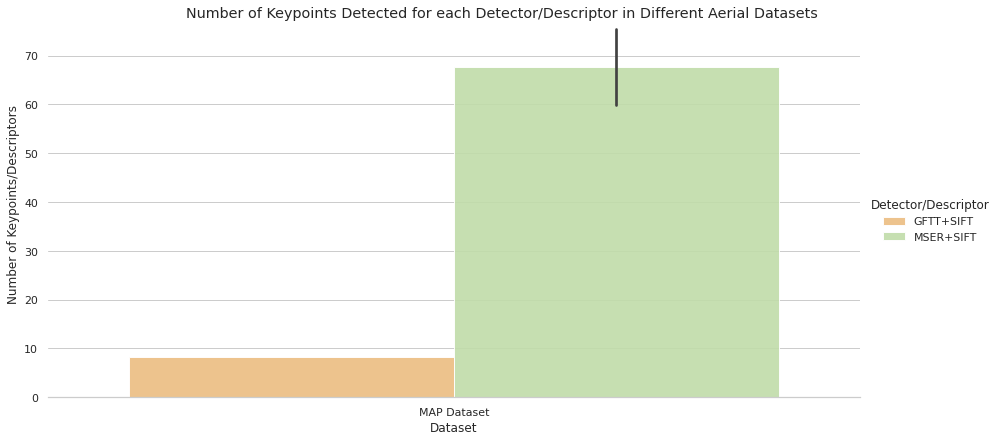

In [55]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_2, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [56]:
g.savefig(f'drive/MyDrive/Num_Kypoints_2_{Dataset}.png')

In [57]:
df_numkey_2.to_csv(f'drive/MyDrive/Num_Kypoints_2_{Dataset}.csv')

Total Number of Matches Detected for each Detector+Descriptor

In [58]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_gftt + num_matches_mser, 'Detector/Descriptor':['GFTT+SIFT']*(len_files-1) + ['MSER+SIFT']*(len_files-1) }
df_match_2 = pd.DataFrame(data=d)
df_match_2['Number of Total Matches'] = df_match_2['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

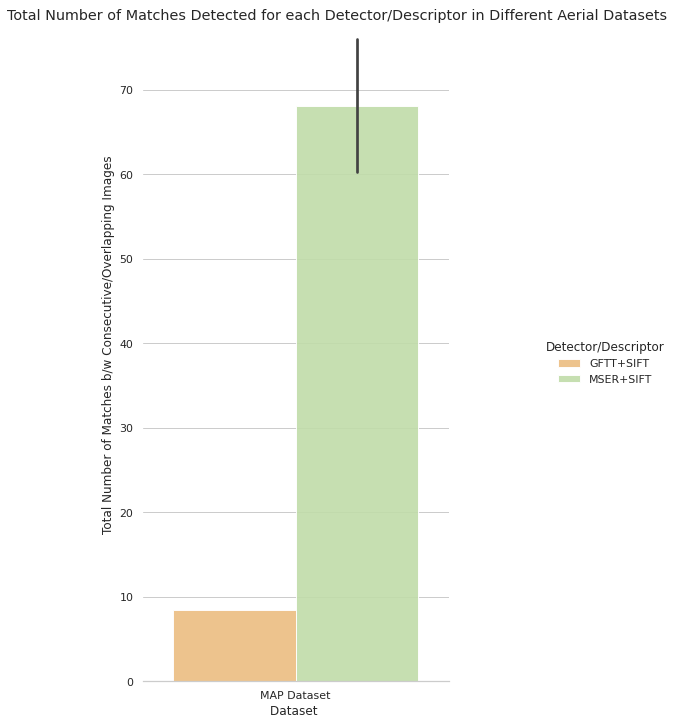

In [59]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_2, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [60]:
g.savefig(f'drive/MyDrive/Num_Matches_2_{Dataset}.png')

Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor

In [61]:
df_match_2['Number of Good Matches'] = num_good_matches_gftt + num_good_matches_mser 
df_match_2['Number of Good Matches'] = df_match_2['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

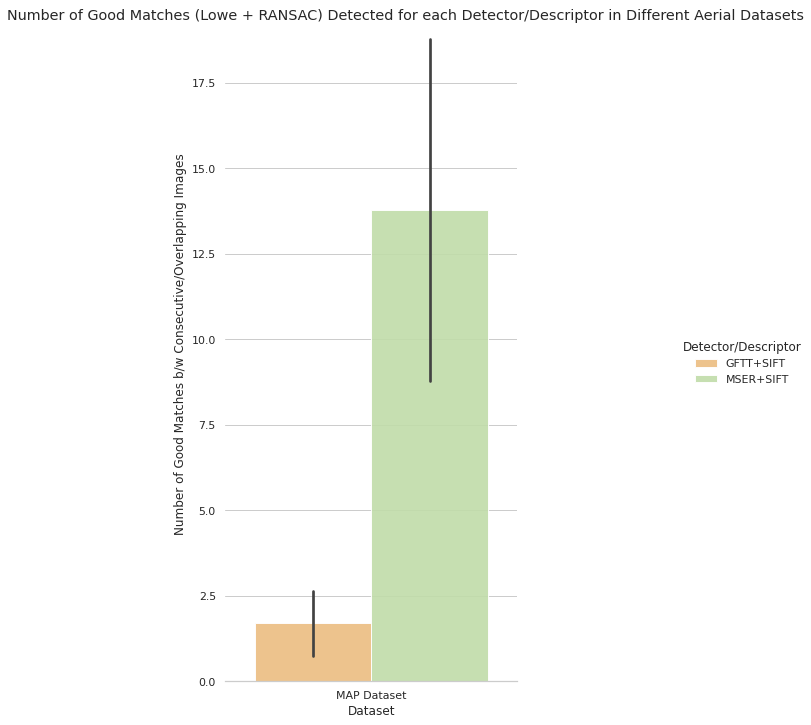

In [62]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_2, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [63]:
g.savefig(f'drive/MyDrive/Num_Good_Matches_2_{Dataset}.png')

Recall Rate for each Detector+Descriptor

In [64]:
df_match_2['Recall Rate of Matches'] = df_match_2['Number of Good Matches']/df_match_2['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

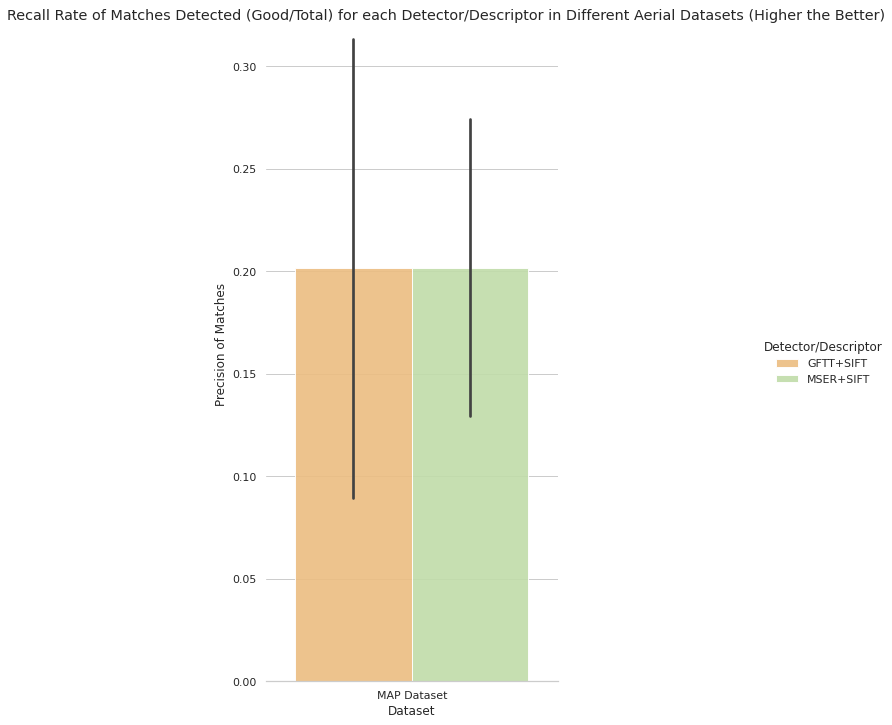

In [65]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_2, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [66]:
g.savefig(f'drive/MyDrive/Recall_Rate_Matches_2_{Dataset}.png')

1-Precision Rate for each Detector+Descriptor

In [67]:
df_match_2['1 - Precision Rate of Matches'] = (df_match_2['Number of Total Matches'] - df_match_2['Number of Good Matches'])/df_match_2['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

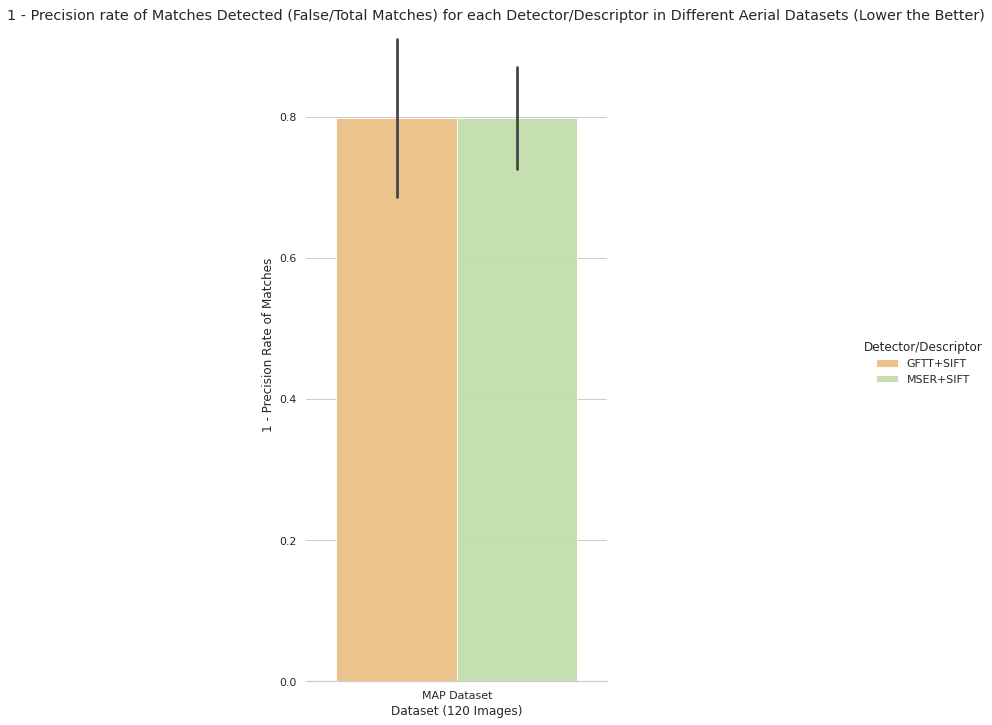

In [68]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_2, kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (120 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [69]:
g.savefig(f'drive/MyDrive/One_minus_Precision_Rate_Matches_2_{Dataset}.png')

F-Score for each Detector+Descriptor

In [70]:
df_match_2['F-Score'] = (2* (1 - df_match_2['1 - Precision Rate of Matches']) * df_match_2['Recall Rate of Matches'])/((1 - df_match_2['1 - Precision Rate of Matches']) + df_match_2['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

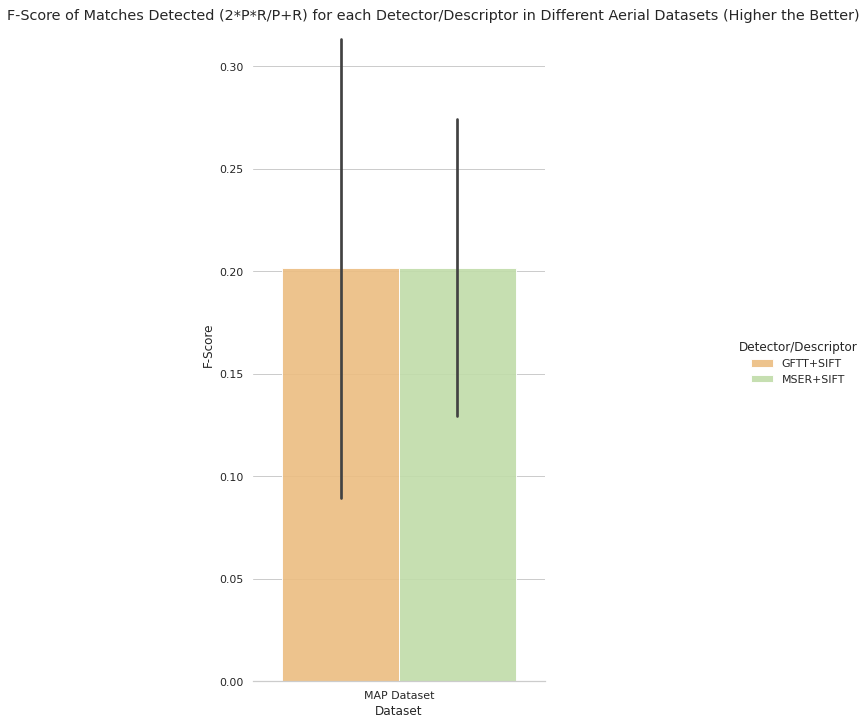

In [71]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_2, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [72]:
g.savefig(f'drive/MyDrive/F_Score_Rate_Matches_2_{Dataset}.png')

In [73]:
df_match_2.to_csv(f'drive/MyDrive/All_metrics_2_{Dataset}.csv')

Time for each Detector+Descriptor

In [74]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time': [time_all[0]] + [time_all[1]] , 'Detector/Descriptor': ['GFTT+SIFT']*(1) + ['MSER+SIFT']*(1)} 
df_time_2 = pd.DataFrame(data=d)

Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

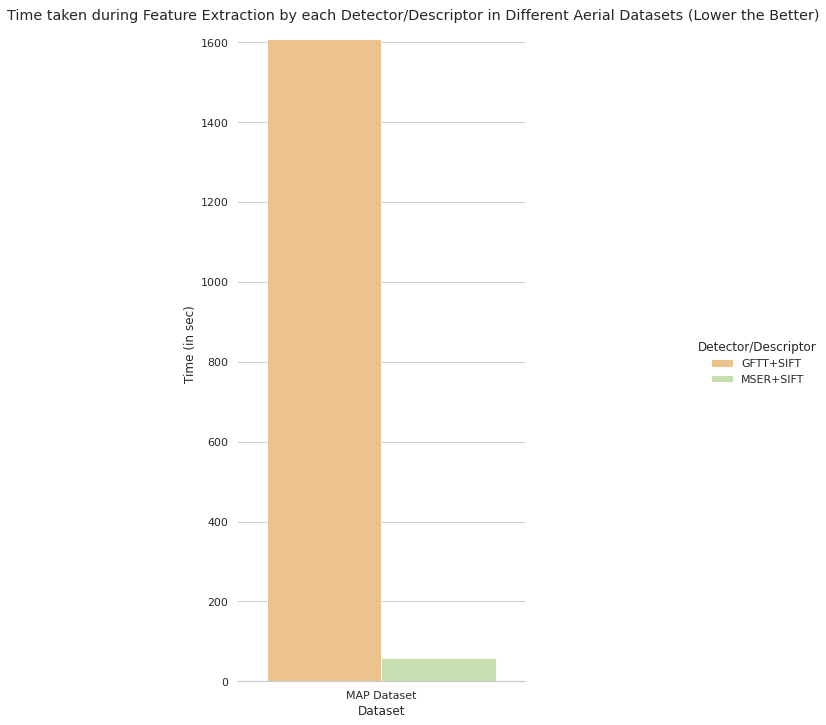

In [75]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_2, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [76]:
g.savefig(f'drive/MyDrive/Time_2_{Dataset}.png')

In [77]:
df_time_2.to_csv(f'drive/MyDrive/Time_2_{Dataset}.csv')